In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [9]:
#Imports and cleans the data
from clean import cleaning

def import_data(url):
    shark_df = pd.read_excel(url)
    shark_df.dropna(axis=1, how='all', inplace=True)
    shark_df.dropna(axis=0, how='all', inplace=True)
    return shark_df

shark_df = import_data("https://www.sharkattackfile.net/spreadsheets/GSAF5.xls")

shark_df = cleaning(shark_df)

In [10]:
shark_df.info()



<class 'pandas.core.frame.DataFrame'>
Index: 4454 entries, 0 to 5541
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        4454 non-null   datetime64[ns]
 1   Year        4454 non-null   float64       
 2   Type        4444 non-null   object        
 3   Country     4454 non-null   object        
 4   State       4454 non-null   object        
 5   Location    4383 non-null   object        
 6   Activity    4454 non-null   object        
 7   Name        4396 non-null   object        
 8   Sex         4170 non-null   object        
 9   Age         1437 non-null   float64       
 10  Injury      4439 non-null   object        
 11  Fatal       4454 non-null   object        
 12  Time        2814 non-null   object        
 13  Species     2750 non-null   object        
 14  Source      4443 non-null   object        
 15  Age Group   4454 non-null   object        
 16  Hemisphere  4454 non-null   o

In [11]:
#Analysis

print(shark_df[shark_df["Age Group"] != "Unknown"]["Age Group"].value_counts())

Age Group
10-19    438
20-29    393
30-39    228
40-49    161
50-59     94
0-9       60
60-69     49
70-79     11
80-89      3
Name: count, dtype: int64


In [12]:
shark_df["Fatal"].value_counts()

Fatal
N          3511
Y           593
UNKNOWN     350
Name: count, dtype: int64

In [13]:
shark_df.groupby(['Activity', 'Fatal']).size().reset_index(name='Counts')

,Activity,Fatal,Counts
0,Body Surfing,N,86
1,Body Surfing,UNKNOWN,2
2,Body Surfing,Y,21
3,Boogie Boarding,N,48
4,Boogie Boarding,UNKNOWN,3
5,Boogie Boarding,Y,3
6,Canoeing,N,9
7,Diving,N,194
8,Diving,UNKNOWN,23
9,Diving,Y,38


In [14]:
shark_df.groupby(['Type', 'Sex']).size().reset_index(name='Counts')

,Type,Sex,Counts
0,Provoked,F,19
1,Provoked,M,349
2,Unknown,F,56
3,Unknown,M,397
4,Unprovoked,F,489
5,Unprovoked,M,2850


In [15]:
shark_df.pivot_table(index="Season", columns="Age Group", aggfunc='size', fill_value=0)

Age Group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,Unknown
Season,,,,,,,,,,
Fall,17,109,107,61,45,27,10,3,1,742
Spring,8,79,76,50,24,24,15,4,1,600
Summer,34,204,157,79,68,30,18,1,1,1258
Unknown,0,19,11,6,3,0,0,0,0,73
Winter,1,27,42,32,21,13,6,3,0,344


In [16]:
viz_sex_and_activity = shark_df.groupby(['Activity', 'Sex']).size().unstack().fillna(0).astype(int)
viz_sex_and_activity = viz_sex_and_activity.sort_values(by=['F', 'M'], ascending=False)

In [17]:
grouped_activity_season = shark_df.groupby(['Activity', 'Season']).size().unstack().fillna(0).astype(int)
grouped_activity_season = grouped_activity_season.sort_values(by=["Spring", "Summer", "Fall", "Winter", "Unknown"], ascending=False)
grouped_activity_season 

Season,Fall,Spring,Summer,Unknown,Winter
Activity,,,,,
Unknown,293,254,518,15,153
Surfing,358,212,276,43,149
Swimming,155,150,409,40,51
Fishing,78,61,168,1,33
Diving,65,53,96,4,37
Spearfishing,49,47,104,1,22
Wading,49,42,152,2,5
Body Surfing,33,22,38,4,12
Kayaking,10,9,12,0,5


<Axes: xlabel='Count', ylabel='Activity'>

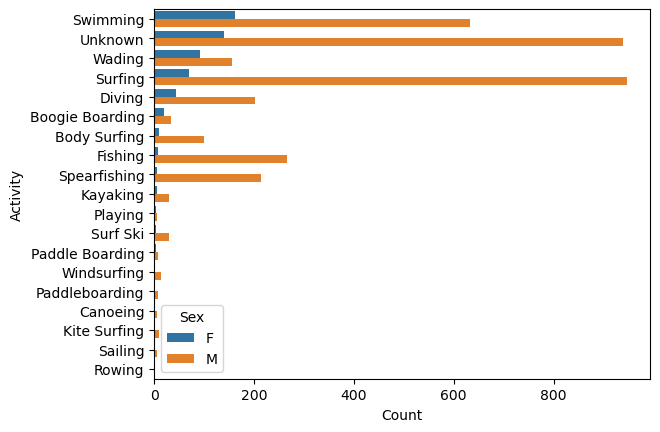

In [32]:
def vizualize_acitvity_sex_group(df):
    viz_sex_and_activity = shark_df.groupby(['Activity', 'Sex']).size().unstack().fillna(0).astype(int)
    viz_sex_and_activity = viz_sex_and_activity.sort_values(by=['F', 'M'], ascending=False)
    viz_sex_and_activity.reset_index(inplace=True)
    viz_sex_and_activity = viz_sex_and_activity.melt(id_vars='Activity', var_name='Sex', value_name='Count')
    return sns.barplot(data=viz_sex_and_activity, y='Activity', x='Count', hue='Sex')

vizualize_acitvity_sex_group(shark_df)

<Axes: xlabel='Count', ylabel='Age Group'>

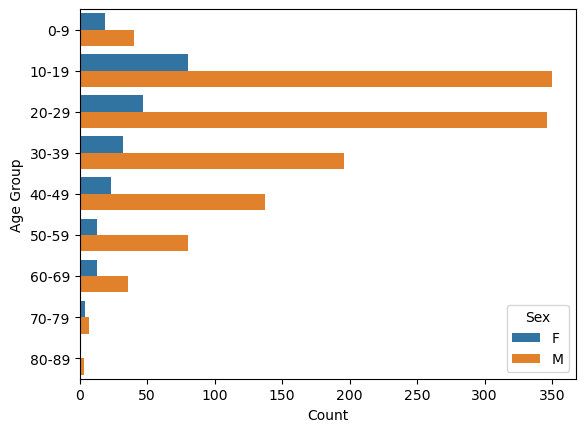

In [36]:
def vizualize_age_sex_group(df):

    df = df[df['Age Group'] != 'Unknown']
    viz_sex_and_activity = df.groupby(['Age Group', 'Sex']).size().unstack().fillna(0).astype(int)
    viz_sex_and_activity.reset_index(inplace=True)
    viz_sex_and_activity = viz_sex_and_activity.melt(id_vars='Age Group', var_name='Sex', value_name='Count')
    viz_sex_and_activity.sort_values(by='Age Group', inplace=True)
    return sns.barplot(data=viz_sex_and_activity, y='Age Group', x='Count', hue='Sex')

vizualize_age_sex_group(shark_df)

<Axes: xlabel='Count', ylabel='Activity'>

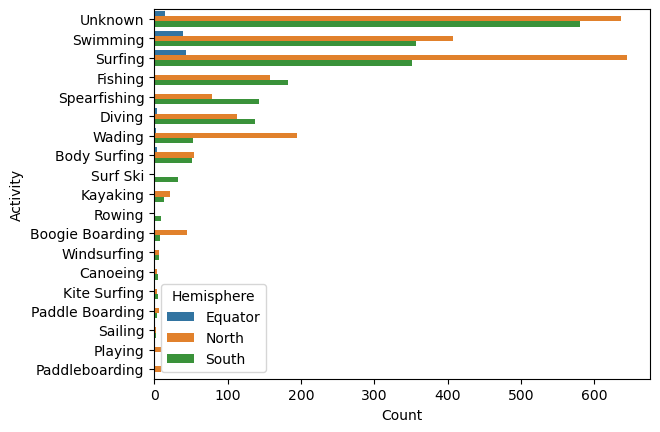

In [38]:
def grouped_activity_hemisphere(df):
    grouped_activity_hemisphere = shark_df.groupby(['Activity', 'Hemisphere']).size().unstack().fillna(0).astype(int)
    grouped_activity_hemisphere = grouped_activity_hemisphere.sort_values(by=["South", "North", "Equator"], ascending=False)
    grouped_activity_hemisphere.reset_index(inplace=True)
    grouped_activity_hemisphere = grouped_activity_hemisphere.melt(id_vars = "Activity", var_name = "Hemisphere", value_name = "Count")
    return sns.barplot(data=grouped_activity_hemisphere, y='Activity', x='Count', hue='Hemisphere')

grouped_activity_hemisphere(shark_df)

<Axes: xlabel='Month', ylabel='Count'>

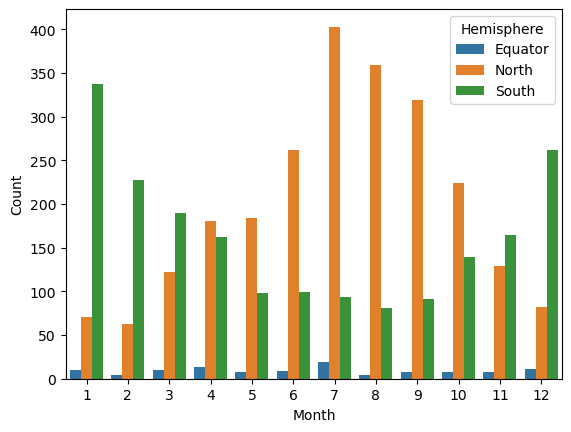

In [42]:
def grouped_month_hemisphere(df):
    grouped_activity_hemisphere = shark_df.groupby(['Month', 'Hemisphere']).size().unstack().fillna(0).astype(int)
    grouped_activity_hemisphere = grouped_activity_hemisphere.sort_values(by=["South", "North", "Equator"], ascending=False)
    grouped_activity_hemisphere.reset_index(inplace=True)
    grouped_activity_hemisphere = grouped_activity_hemisphere.melt(id_vars = "Month", var_name = "Hemisphere", value_name = "Count")
    return sns.barplot(data=grouped_activity_hemisphere, y='Count', x='Month', hue='Hemisphere')

grouped_month_hemisphere(shark_df)

<Axes: xlabel='Decade', ylabel='Count'>

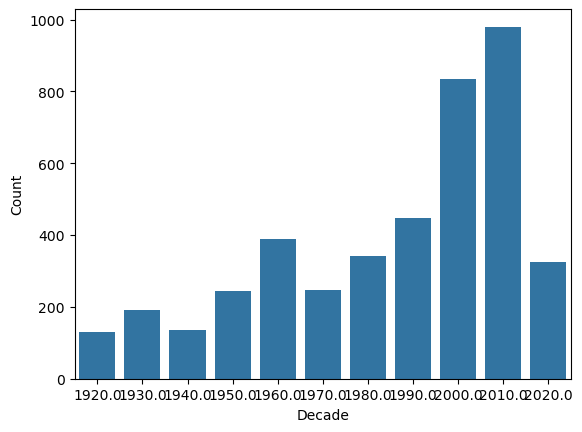

In [74]:
def grouped_decade_incidents(df):

    df["Decade"] = ( df["Year"] // 10 ) * 10
    df = df[(df['Decade'] >= 1920) & (df['Decade'] <= 2010)]
    grouped_activity_year = df.groupby('Decade').size().reset_index(name='Count')
    
    return sns.barplot(data=grouped_activity_year, x='Decade', y='Count')

grouped_year_incidents(shark_df)